In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from nltk.corpus import stopwords

In [2]:
import umap
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict

In [39]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ColorMapper
from bokeh.palettes import Spectral10, Spectral, Set1, Viridis

output_notebook()

Loading BokehJS ...

In [5]:
clean_claims = pd.read_csv("clean_claimreviews.csv")
claims = pd.read_json("claims.json")

claims = claims.rename(columns={"@id":"id", "@type": "type"})
keywords = pd.read_csv("all_keywords.csv", index_col=0).rename(columns={"@id":"id", "@type": "type"})
countries = pd.read_csv("all_countries.csv", index_col=0).rename(columns={"@id":"id", "@type": "type"})

In [6]:
keyword_dict = dict(zip(keywords["id"], keywords["name"]))
country_dict = dict(zip(countries["id"], countries["name"]))

In [7]:
claims = claims.assign(keyword_names = [[keyword_dict[keyword] for keyword in row ] for row in claims.keywords])
claims = claims.assign(country_names = [[country_dict[country] for country in row] for row in claims.contentLocations] ) 

In [8]:
clean_claims = pd.merge(clean_claims, claims[["claimReview", "keyword_names", "country_names"]], how="left", left_on="id", right_on="claimReview")

In [9]:
clean_claims = clean_claims.drop_duplicates(subset="claimReviewed")

In [10]:
clean_claims["datePublished"] = pd.to_datetime(clean_claims.datePublished)
clean_claims["yearPublished"] = clean_claims.datePublished.dt.year

In [11]:
def pick_first(name_list):
    if name_list is np.nan or name_list is None or len(name_list) < 1:
        return "-"
    else:
        return name_list[0]

In [12]:
clean_claims = clean_claims.assign(country1 = [pick_first(countries) for countries in clean_claims.country_names],
                   keyword1 = [pick_first(keywords) for keywords in clean_claims.keyword_names])

In [13]:
clean_claims.head(3)

,id,type,claimReviewed,reviewRating,datePublished,itemReviewed,name,html_text,text,claimReview,keyword_names,country_names,yearPublished,country1,keyword1
0,/claim_reviews/20,http://schema.org/ClaimReview,There are British curators behind the persecut...,NaN,2020-01-07 00:00:00+00:00,/claims/20,British curators are behind the persecution of...,<p>This conspiracy theory is based on the conc...,This conspiracy theory is based on the concept...,/claim_reviews/20,"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia],2020,Estonia,Dmitry Kiselyov
1,/claim_reviews/21,http://schema.org/ClaimReview,"I would like to add that, as far as I know, Sp...",NaN,2020-01-07 00:00:00+00:00,/claims/21,There are no lies coming from Sputnik,"<p><a href=""https://euvsdisinfo.eu/three-thing...",Sputnik was created by a Presidential decree w...,/claim_reviews/21,"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia],2020,Estonia,Dmitry Kiselyov
2,/claim_reviews/22,http://schema.org/ClaimReview,We regard the actions of the regime in Estonia...,NaN,2020-01-07 00:00:00+00:00,/claims/22,The regime in Estonia publicly persecutes its ...,"<p>Estonia is ranked as the <a href=""https://r...",Estonia is ranked as the 11th freest country i...,/claim_reviews/22,"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia],2020,Estonia,Dmitry Kiselyov


In [14]:
clean_claims.shape

(7015, 15)

In [15]:
clean_claims = clean_claims[clean_claims.claimReviewed.notnull()]
claim_summary = clean_claims.claimReviewed.values.tolist(); claim_summary[0]

'There are British curators behind the persecution of Sputnik [Estonia] by the Estonian authorities.'

In [16]:
clean_claims.shape

(7014, 15)

## Using Embeddings

In [18]:
from flair.data import Sentence

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence

# initialize the word embeddings
glove_embedding = WordEmbeddings('glove')
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding], fine_tune_mode="nonlinear")

In [19]:
n = len(clean_claims)

In [20]:
sentences = [Sentence(claim) for claim in clean_claims.claimReviewed[0:n] ]

In [21]:
matrix = list()
for sentence in sentences:
    document_embeddings.embed(sentence)
    embedding = sentence.get_embedding()
    matrix.append(embedding.detach().numpy())

In [22]:
np.savetxt("claim_embeddings.csv", np.asarray(matrix), delimiter=",")

In [54]:
reducer = umap.UMAP(n_neighbors=2, metric = "cosine")

In [55]:
umap_embedding = reducer.fit_transform(matrix)
umap_embedding.shape


/home/corrie/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/corrie/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 199 separate connected components using meta-embedding (experimental)
  n_components
/home/corrie/anaconda3/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
 

(7014, 2)

In [60]:
clean_claims["umap_embedding_0"] = umap_embedding[:,0]
clean_claims["umap_embedding_1"] = umap_embedding[:,1]

In [61]:
clean_claims.to_csv("claims_w_emb.csv")

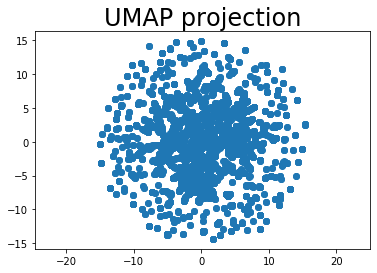

In [56]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);
plt.show()

In [36]:
clean_claims.yearPublished[0:n].unique()

array([2020, 2019, 2018, 2017, 2016, 2015])

In [40]:
claim_df = pd.DataFrame(umap_embedding, columns=('x', 'y'))
claim_df['claim'] = [str(x) for x in clean_claims.claimReviewed.iloc[0:n]]
#claim_df["cluster"] = [str(x) for x in clean_claims.cluster.iloc[0:n]]
claim_df["yearPublished"] = [x for x in clean_claims.yearPublished[0:n]]

datasource = ColumnDataSource(claim_df)
#color_mapping = ColorMapper(factors=[x for x in clean_claims.yearPublished[0:n].unique()],
#                                       palette=Viridis)

plot_figure = figure(
    title='UMAP projection',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div style="width:400px;">
    <span style='font-size: 14px; color: #224499'>Claim:</span>
    <span style='font-size: 12px'>@claim</span><br>
    <span style='font-size: 14px; color: #224499'>Year:</span>
    <span style='font-size: 12px'>@yearPublished</span>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    color=dict(field='yearPublished', transform=color_mapping),
    source=datasource,
    line_alpha=0.6,
    fill_alpha=0.6,
    size=10
)
show(plot_figure)

AttributeError: unexpected attribute 'factors' to ColorMapper, possible attributes are js_event_callbacks, js_property_callbacks, name, nan_color, palette, subscribed_events or tags

In [ ]:
Set1